# Project 2 - Dynamic Hedging

**Author:** Alex Zhang

**Date:** November 23, 2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

pd.set_option('expand_frame_repr', True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

In [2]:
class DeltaGammaHedging:
    def __init__(self, S0, K, K_h, T_g, T_h, r, sigma, mu, N, transaction_cost_stock, transaction_cost_option):
        self.S0 = S0  # Initial asset price
        self.K = K  # Strike price of option g
        self.K_h = K_h  # Strike price of option h
        self.T_g = T_g  # Time to maturity of option g
        self.T_h = T_h  # Time to maturity of option h
        self.r = r  # Risk-free rate
        self.sigma = sigma  # Volatility
        self.mu = mu  # Drift (not used for risk-neutral pricing)
        self.N = N  # Number of options sold
        self.dt = 1 / 252  # Daily time step
        self.transaction_cost_stock = transaction_cost_stock
        self.transaction_cost_option = transaction_cost_option

    def black_scholes_price(self, S, K, T, r, sigma, option_type="call"):
        """Calculate Black-Scholes option price."""
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == "call":
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == "put":
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def delta(self, S, K, T, r, sigma):
        """Calculate Delta of the option."""
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        return norm.cdf(d1)

    def gamma(self, S, K, T, r, sigma):
        """Calculate Gamma of the option."""
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        return norm.pdf(d1) / (S * sigma * np.sqrt(T))

    def simulate_asset_paths(self, num_paths, sigma_real):
        """Simulate asset price paths using Geometric Brownian Motion."""
        num_steps = int(self.T_g / self.dt)
        paths = np.zeros((num_paths, num_steps + 1))
        paths[:, 0] = self.S0
        for t in range(1, num_steps + 1):
            z = np.random.normal(0, 1, num_paths)
            paths[:, t] = paths[:, t - 1] * np.exp(
                (self.mu - 0.5 * sigma_real**2) * self.dt + sigma_real * np.sqrt(self.dt) * z
            )
        return paths

    def delta_hedge(self, paths):
        """Perform Delta hedging and return P&L."""
        num_steps = paths.shape[1]
        pnl = []
        stock_pos = []
        cash_pos = []

        for path in tqdm(paths):
            S = path
            T_g_t = self.T_g

            stock_position = []
            cash_position = []
            portfolio_value = []

            for t in range(num_steps):
                T_g_t -= self.dt
                if t == 0:

                    # Calculate option prices
                    price_g = self.black_scholes_price(S[t], self.K, T_g_t, self.r, self.sigma)

                    # Calculate option Greeks
                    delta_g = self.delta(S[t], self.K, T_g_t, self.r, self.sigma)

                    # Determine target positions
                    target_stock_position = round(self.N * delta_g)

                    # Settlement in cash
                    cash = self.N * price_g - target_stock_position * S[t]

                    # Calculate transaction costs
                    cash -= abs(target_stock_position) * self.transaction_cost_stock

                    # Update positions
                    stock_position.append(target_stock_position)
                    cash_position.append(cash)

                    # Calculate final P&L
                    final_value = target_stock_position * S[t] + cash - self.N * price_g
                    portfolio_value.append(final_value)

                elif T_g_t > 0:

                    # Calculate option prices
                    price_g = self.black_scholes_price(S[t], self.K, T_g_t, self.r, self.sigma)

                    # Calculate option Greeks
                    delta_g = self.delta(S[t], self.K, T_g_t, self.r, self.sigma)

                    # Determine target positions
                    target_stock_position = round(self.N * delta_g)

                    # Reinvest cash
                    cash = cash_position[-1] * np.exp(self.r * self.dt)

                    # Settlement in cash
                    cash -= (target_stock_position - stock_position[-1]) * S[t]

                    # Calculate transaction costs
                    cash -= abs(target_stock_position - stock_position[-1]) * self.transaction_cost_stock

                    # Update positions
                    stock_position.append(target_stock_position)
                    cash_position.append(cash)

                    # Calculate final P&L
                    final_value = target_stock_position * S[t] + cash - self.N * price_g
                    portfolio_value.append(final_value)

                else:

                    # Calculate option exercise value
                    price_g = max(S[t] - self.K, 0)

                    # Reinvest cash
                    cash = cash_position[-1] * np.exp(self.r * self.dt)

                    # Clear the hedging positions
                    cash += stock_position[-1] * S[t]

                    # Calculate transaction costs
                    cash -= abs(stock_position[-1]) * self.transaction_cost_stock

                    # Update positions
                    stock_position.append(0)
                    cash_position.append(cash)

                    # Calculate final P&L
                    final_value = cash - self.N * price_g
                    portfolio_value.append(final_value)

            pnl.append(np.array(portfolio_value))
            stock_pos.append(np.array(stock_position))
            # cash_pos.append(np.array(cash_position))

        return np.array(pnl), np.array(stock_pos)

    def delta_gamma_hedge(self, paths):
        """Perform Delta-Gamma hedging and return P&L."""
        num_steps = paths.shape[1]
        pnl = []
        stock_pos = []
        option_pos = []
        cash_pos = []

        for path in tqdm(paths):
            S = path
            T_g_t = self.T_g
            T_h_t = self.T_h

            stock_position = []
            option_h_position = []
            cash_position = []
            portfolio_value = []

            for t in range(num_steps):
                T_g_t -= self.dt
                T_h_t -= self.dt
                if t == 0:

                    # Calculate option prices
                    price_g = self.black_scholes_price(S[t], self.K, T_g_t, self.r, self.sigma)
                    price_h = self.black_scholes_price(S[t], self.K_h, T_h_t, self.r, self.sigma)

                    # Calculate option Greeks
                    delta_g = self.delta(S[t], self.K, T_g_t, self.r, self.sigma)
                    gamma_g = self.gamma(S[t], self.K, T_g_t, self.r, self.sigma)
                    delta_h = self.delta(S[t], self.K_h, T_h_t, self.r, self.sigma)
                    gamma_h = self.gamma(S[t], self.K_h, T_h_t, self.r, self.sigma)

                    # Determine target positions
                    target_option_h_position = round((gamma_g / gamma_h) * self.N)
                    target_stock_position = round(self.N * delta_g - target_option_h_position * delta_h)

                    # Settlement in cash
                    cash = self.N * price_g - target_stock_position * S[t] - target_option_h_position * price_h

                    # Calculate transaction costs
                    cash -= abs(target_stock_position) * self.transaction_cost_stock
                    cash -= abs(target_option_h_position) * self.transaction_cost_option

                    # Update positions
                    stock_position.append(target_stock_position)
                    option_h_position.append(target_option_h_position)
                    cash_position.append(cash)

                    # Calculate final P&L
                    final_value = target_stock_position * S[t] + target_option_h_position * price_h + cash - self.N * price_g
                    portfolio_value.append(final_value)

                elif T_g_t > 0:

                    # Calculate option prices
                    price_g = self.black_scholes_price(S[t], self.K, T_g_t, self.r, self.sigma)
                    price_h = self.black_scholes_price(S[t], self.K_h, T_h_t, self.r, self.sigma)

                    # Calculate option Greeks
                    delta_g = self.delta(S[t], self.K, T_g_t, self.r, self.sigma)
                    gamma_g = self.gamma(S[t], self.K, T_g_t, self.r, self.sigma)
                    delta_h = self.delta(S[t], self.K_h, T_h_t, self.r, self.sigma)
                    gamma_h = self.gamma(S[t], self.K_h, T_h_t, self.r, self.sigma)

                    # Determine target positions
                    target_option_h_position = round((gamma_g / gamma_h) * self.N)
                    target_stock_position = round(self.N * delta_g - target_option_h_position * delta_h)

                    # Reinvest cash
                    cash = cash_position[-1] * np.exp(self.r * self.dt)

                    # Settlement in cash
                    cash -= (target_stock_position - stock_position[-1]) * S[t]
                    cash -= (target_option_h_position - option_h_position[-1]) * price_h

                    # Calculate transaction costs
                    cash -= abs(target_stock_position - stock_position[-1]) * self.transaction_cost_stock
                    cash -= abs(target_option_h_position - option_h_position[-1]) * self.transaction_cost_option

                    # Update positions
                    stock_position.append(target_stock_position)
                    option_h_position.append(target_option_h_position)
                    cash_position.append(cash)

                    # Calculate final P&L
                    final_value = target_stock_position * S[t] + target_option_h_position * price_h + cash - self.N * price_g
                    portfolio_value.append(final_value)

                else:

                    # Calculate option exercise value
                    price_g = max(S[t] - self.K, 0)
                    price_h = self.black_scholes_price(S[t], self.K_h, T_h_t, self.r, self.sigma)

                    # Reinvest cash
                    cash = cash_position[-1] * np.exp(self.r * self.dt)

                    # Clear the hedging positions
                    cash += stock_position[-1] * S[t]
                    cash += option_h_position[-1] * price_h

                    # Calculate transaction costs
                    cash -= abs(stock_position[-1]) * self.transaction_cost_stock
                    cash -= abs(option_h_position[-1]) * self.transaction_cost_option

                    # Update positions
                    stock_position.append(0)
                    option_h_position.append(0)
                    cash_position.append(cash)

                    # Calculate final P&L
                    final_value = cash - self.N * price_g
                    portfolio_value.append(final_value)

            pnl.append(np.array(portfolio_value))
            stock_pos.append(np.array(stock_position))
            option_pos.append(np.array(option_h_position))
            # cash_pos.append(np.array(cash_position))

        return np.array(pnl), np.array(stock_pos), np.array(option_pos)


### Q1. Plot PnL Distribution as $\mu$ varys

100%|██████████| 5000/5000 [05:40<00:00, 14.69it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   2.,   1.,   1.,   1.,
          1.,   0.,   2.,   0.,   0.,   3.,   4.,   3.,   1.,   2.,   1.,
          5.,   4.,   2.,   6.,   7.,   9.,   8.,   8.,  13.,   9.,  18.,
         21.,  21.,  24.,  38.,  49.,  53.,  61.,  63.,  86., 112., 119.,
        172., 179., 206., 224., 256., 306., 352., 348., 338., 292., 276.,
        251., 195., 182., 144.,  95.,  99.,  71.,  52.,  48.,  37.,  25.,
         19.,  18.,  18.,   9.,   6.,   6.,   3.,   2.,   0.,   3.,   0.,
          1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4678.37768939, -4605.86065771, -4533.34362602, -4460.82659434,
        -4388.30956265, -4315.79253097, -4243.27549929, -4170.7584676 ,
        -4098.24143592, -4025.72440424, -3953.20737255, -3880.69034087,
        -3808.17330918, -3735.6562775 , -3663.13924582, -3590.62221413,
        -3518.10518245, -3445.

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 6.000e+00,
        3.000e+00, 4.000e+00, 5.000e+00, 6.000e+00, 3.000e+00, 6.000e+00,
        7.000e+00, 7.000e+00, 9.000e+00, 7.000e+00, 6.000e+00, 5.000e+00,
        6.000e+00, 5.000e+00, 1.000e+01, 1.100e+01, 1.600e+01, 1.300e+01,
        3.700e+01, 4.800e+01, 6.100e+0

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = -0.20')

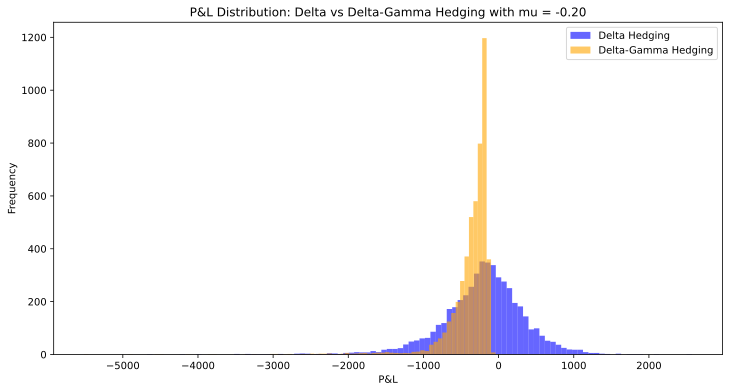

100%|██████████| 5000/5000 [05:46<00:00, 14.44it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   2.,   2.,   2.,   0.,   2.,   0.,
          2.,   0.,   2.,   3.,   1.,   5.,   4.,   7.,   6.,   8.,   8.,
          4.,   8.,   4.,   5.,  10.,  18.,  13.,  11.,  13.,  12.,  18.,
         23.,  24.,  32.,  36.,  39.,  55.,  56.,  61.,  71.,  80.,  95.,
        126., 153., 144., 189., 207., 250., 211., 273., 276., 277., 234.,
        263., 262., 211., 176., 177., 139., 119.,  90.,  82.,  77.,  51.,
         44.,  44.,  30.,  26.,  20.,  20.,  13.,  15.,  14.,  12.,   7.,
          4.,   4.,   3.,   1.,   2.,   1.,   2.,   1.,   2.,   1.,   0.,
          1.]),
 array([-4071.12445784, -4010.27013465, -3949.41581146, -3888.56148827,
        -3827.70716508, -3766.8528419 , -3705.99851871, -3645.14419552,
        -3584.28987233, -3523.43554914, -3462.58122596, -3401.72690277,
        -3340.87257958, -3280.01825639, -3219.1639332 , -3158.30961002,
        -3097.45528683, -3036.

(array([  2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   2.,   0.,   1.,
          1.,   3.,   1.,   2.,   0.,   2.,   3.,   0.,   1.,   3.,   2.,
          4.,   3.,   1.,   2.,   2.,   4.,   5.,   1.,   4.,   5.,   1.,
          3.,   2.,   9.,   4.,   3.,   4.,   1.,   4.,   4.,   7.,   9.,
          6.,   6.,   7.,  17.,   8.,  22.,  31.,  43.,  58.,  57., 110.,
        111., 132., 231., 307., 415., 560., 637., 542., 778., 773.,  30.,
          3.,   3.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4217.56900353, -4163.8878852 , -4110.20676686, -4056.52564853,
        -4002.8445302 , -3949.16341186, -3895.48229353, -3841.80117519,
        -3788.12005686, -3734.43893853, -3680.75782019, -3627.07670186,
        -3573.39558353, -3519.71446519, -3466.03334686, -3412.35222853,
        -3358.67111019, -3304.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = -0.10')

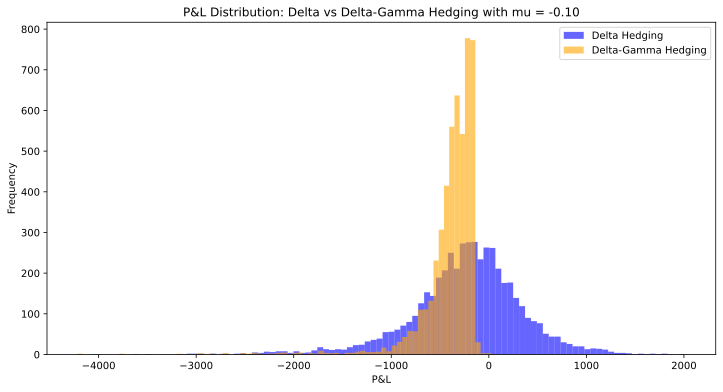

100%|██████████| 5000/5000 [05:44<00:00, 14.50it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   2.,   1.,   0.,
          0.,   1.,   1.,   1.,   4.,   1.,   1.,   1.,   2.,   3.,   0.,
          4.,   1.,   2.,   2.,   0.,   4.,   0.,   5.,   8.,   6.,   5.,
         13.,  11.,  12.,  15.,   8.,  15.,  16.,  18.,  25.,  21.,  29.,
         45.,  43.,  53.,  61.,  48.,  55.,  74., 117.,  93., 129., 161.,
        195., 190., 204., 263., 248., 296., 275., 281., 257., 263., 238.,
        222., 151., 146., 103., 108.,  86.,  78.,  61.,  41.,  32.,  29.,
         17.,  25.,  18.,  12.,  10.,  12.,   2.,   2.,   2.,   2.,   4.,
          2.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4066.385408  , -4002.71288627, -3939.04036453, -3875.3678428 ,
        -3811.69532106, -3748.02279933, -3684.35027759, -3620.67775586,
        -3557.00523412, -3493.33271239, -3429.66019065, -3365.98766892,
        -3302.31514718, -3238.64262545, -3174.97010371, -3111.29758198,
        -3047.62506024, -2983.

(array([  2.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   2.,
          1.,   0.,   1.,   1.,   1.,   1.,   2.,   0.,   1.,   1.,   3.,
          3.,   1.,   3.,   0.,   3.,   4.,   3.,   4.,   2.,   3.,   2.,
          3.,   4.,   6.,   6.,   7.,   5.,   3.,   6.,   7.,   5.,   8.,
          2.,   5.,   5.,   6.,   7.,  12.,  16.,  27.,  41.,  42.,  47.,
         63.,  82., 115., 170., 211., 313., 433., 613., 742., 608., 601.,
        647.,  68.,   3.,   1.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4320.83362977, -4267.30902   , -4213.78441024, -4160.25980047,
        -4106.73519071, -4053.21058095, -3999.68597118, -3946.16136142,
        -3892.63675166, -3839.11214189, -3785.58753213, -3732.06292236,
        -3678.5383126 , -3625.01370284, -3571.48909307, -3517.96448331,
        -3464.43987354, -3410.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = 0.00')

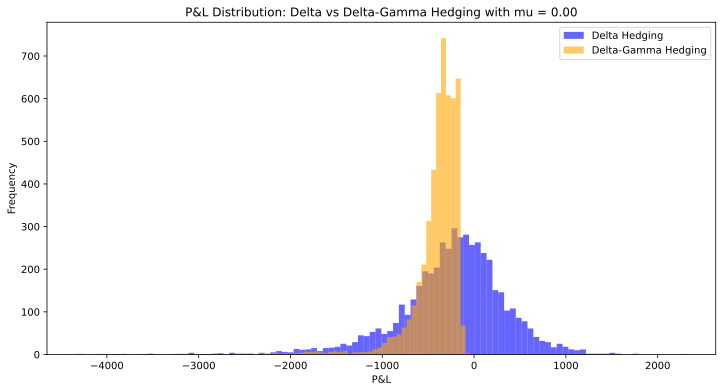

100%|██████████| 5000/5000 [05:48<00:00, 14.36it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   1.,   1.,   3.,   1.,   0.,   0.,   0.,
          2.,   1.,   2.,   2.,   2.,   4.,   3.,   2.,   1.,   4.,   4.,
          7.,   3.,   3.,   4.,   7.,   8.,  14.,  11.,  16.,  15.,  15.,
         20.,  23.,  23.,  27.,  34.,  39.,  39.,  34.,  54.,  64.,  76.,
         87., 101.,  97., 124., 139., 187., 206., 218., 221., 254., 292.,
        281., 271., 282., 239., 212., 199., 172., 151., 110., 111.,  77.,
         74.,  62.,  59.,  29.,  34.,  27.,  19.,  20.,  16.,  11.,   6.,
         10.,  12.,   6.,   3.,   2.,   2.,   0.,   1.,   1.,   2.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3572.1817357 , -3510.73956744, -3449.29739919, -3387.85523094,
        -3326.41306268, -3264.97089443, -3203.52872617, -3142.08655792,
        -3080.64438966, -3019.20222141, -2957.76005316, -2896.3178849 ,
        -2834.87571665, -2773.43354839, -2711.99138014, -2650.54921188,
        -2589.10704363, -2527.

(array([  1.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,
          2.,   3.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          0.,   2.,   3.,   1.,   3.,   1.,   2.,   1.,   2.,   2.,   0.,
          2.,   2.,   2.,   2.,   1.,   0.,   1.,   1.,   3.,   1.,   2.,
          2.,   2.,   2.,   3.,   1.,   1.,   2.,   2.,   2.,   5.,   4.,
          4.,   7.,   3.,   4.,   5.,   2.,   6.,   6.,   8.,   5.,   4.,
          5.,   5.,  14.,  10.,  14.,  19.,  23.,  28.,  47.,  43.,  58.,
         75.,  69., 111., 127., 151., 206., 211., 270., 390., 480., 567.,
        525., 346., 344., 420., 270.,  31.,   4.,   1.,   2.,   0.,   1.,
          1.]),
 array([-3563.99841272, -3527.19670698, -3490.39500124, -3453.5932955 ,
        -3416.79158976, -3379.98988403, -3343.18817829, -3306.38647255,
        -3269.58476681, -3232.78306107, -3195.98135533, -3159.17964959,
        -3122.37794385, -3085.57623811, -3048.77453237, -3011.97282663,
        -2975.17112089, -2938.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = 0.10')

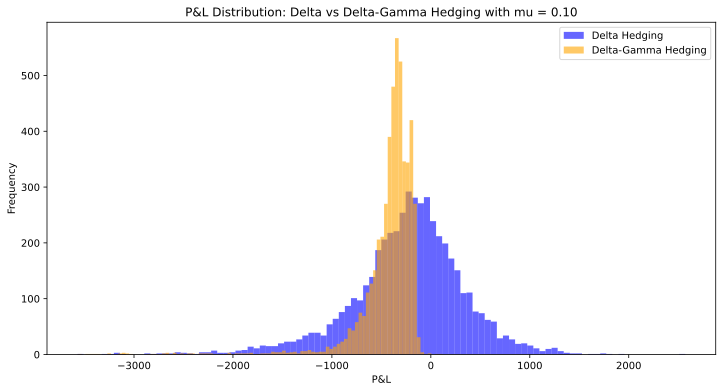

100%|██████████| 5000/5000 [05:45<00:00, 14.48it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   2.,   0.,
          2.,   0.,   1.,   0.,   4.,   2.,   1.,   1.,   0.,   0.,   1.,
          4.,   2.,   2.,   5.,   0.,   3.,   4.,   9.,   6.,  10.,   6.,
          5.,  14.,   9.,  14.,  18.,  22.,  21.,  22.,  21.,  39.,  45.,
         57.,  56.,  69.,  87.,  91.,  96., 100., 122., 156., 189., 206.,
        245., 267., 278., 275., 276., 267., 241., 270., 236., 191., 157.,
        149., 109.,  86.,  77.,  69.,  39.,  41.,  44.,  36.,  23.,  20.,
         19.,  15.,  10.,   5.,   8.,   3.,   5.,   1.,   3.,   2.,   1.,
          1.]),
 array([-4523.37382866, -4461.14983271, -4398.92583676, -4336.70184081,
        -4274.47784486, -4212.25384891, -4150.02985296, -4087.80585701,
        -4025.58186106, -3963.35786511, -3901.13386916, -3838.90987321,
        -3776.68587726, -3714.46188131, -3652.23788536, -3590.01388941,
        -3527.78989346, -3465.

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 6.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 8.000e+00, 5.000e+00, 6.000e+00, 7.000e+00, 3.000e+00,
        5.000e+00, 2.000e+00, 6.000e+00, 9.000e+00, 1.800e+01, 2.300e+01,
        2.400e+01, 2.500e+01, 5.200e+01, 5.900e+01, 8.000e+01, 1.190e+02,
        1.540e+02, 2.070e+02, 3.400e+02, 5.590e+02, 8.890e+02, 1.118e+03,
        5.830e+02, 5.020e+02, 1.370e+0

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = 0.20')

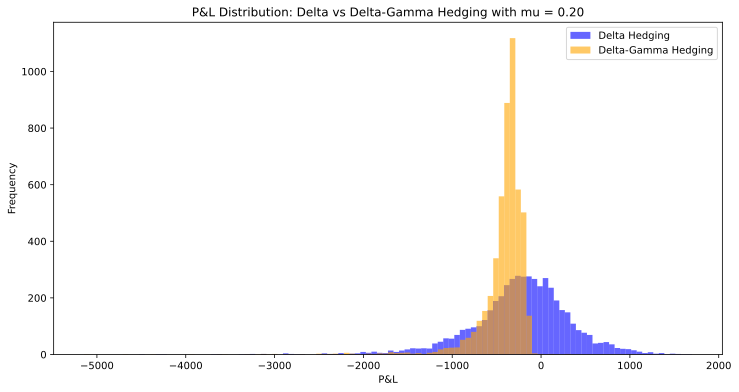

100%|██████████| 5000/5000 [05:28<00:00, 15.21it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,
          0.,   1.,   0.,   1.,   1.,   1.,   1.,   2.,   0.,   1.,   3.,
          2.,   1.,   1.,   1.,   3.,   2.,   4.,   2.,   3.,   4.,   4.,
          3.,   8.,   4.,   8.,   7.,   5.,   8.,  10.,  21.,  10.,  17.,
         17.,  24.,  22.,  33.,  38.,  41.,  44.,  48.,  74.,  78., 108.,
        138., 148., 158., 190., 218., 233., 258., 275., 240., 311., 282.,
        281., 245., 218., 218., 154., 151., 114.,  97.,  76.,  72.,  40.,
         36.,  33.,  25.,  26.,  18.,   9.,  12.,  12.,   7.,  12.,   5.,
          2.,   6.,   1.,   6.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.]),
 array([-4020.22408508, -3960.41526188, -3900.60643868, -3840.79761549,
        -3780.98879229, -3721.17996909, -3661.3711459 , -3601.5623227 ,
        -3541.7534995 , -3481.94467631, -3422.13585311, -3362.32702991,
        -3302.51820671, -3242.70938352, -3182.90056032, -3123.09173712,
        -3063.28291393, -3003.

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        4.000e+00, 2.000e+00, 4.000e+00, 7.000e+00, 3.000e+00, 6.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 7.000e+00, 4.000e+00, 6.000e+00, 8.000e+00,
        1.800e+01, 1.500e+01, 1.600e+01, 3.200e+01, 3.000e+01, 3.000e+01,
        4.300e+01, 7.400e+01, 8.500e+0

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = 0.40')

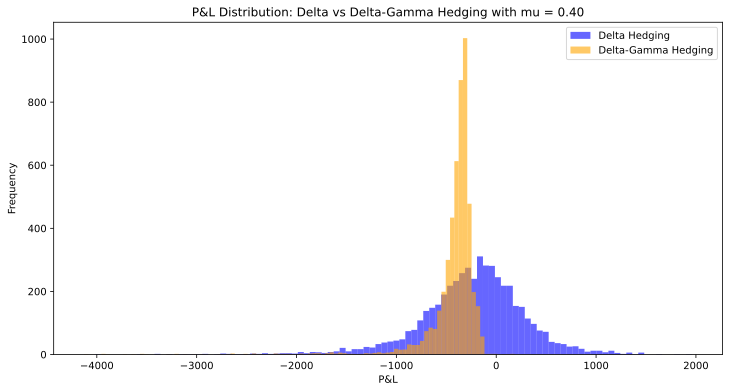

100%|██████████| 5000/5000 [05:28<00:00, 15.24it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   2.,   0.,   2.,   0.,   4.,
          2.,   2.,   2.,   2.,   3.,   2.,   1.,   3.,   4.,   6.,   5.,
          5.,   6.,  19.,  15.,  13.,  15.,  17.,  17.,  25.,  29.,  27.,
         37.,  39.,  62.,  62.,  87.,  99., 107., 118., 132., 175., 211.,
        218., 293., 287., 313., 301., 314., 289., 278., 259., 178., 171.,
        140., 108.,  81.,  69.,  56.,  51.,  49.,  32.,  34.,  20.,  19.,
         15.,  11.,  11.,   7.,   7.,   4.,   6.,   4.,   1.,   5.,   1.,
          1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([-3710.41721319, -3651.39512252, -3592.37303184, -3533.35094117,
        -3474.32885049, -3415.30675981, -3356.28466914, -3297.26257846,
        -3238.24048779, -3179.21839711, -3120.19630644, -3061.17421576,
        -3002.15212508, -2943.13003441, -2884.10794373, -2825.08585306,
        -2766.06376238, -2707.

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        9.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 6.000e+00,
        2.000e+00, 1.000e+01, 4.000e+00, 5.000e+00, 1.100e+01, 6.000e+00,
        1.100e+01, 1.500e+01, 1.800e+01, 2.200e+01, 3.300e+01, 3.400e+01,
        3.600e+01, 6.000e+01, 7.400e+0

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = 0.60')

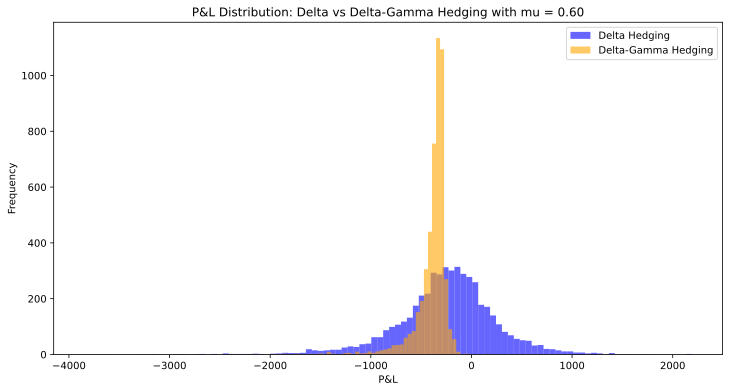

In [3]:
# Parameters
S0 = 10
K = 10
K_h = 10
T_g = 63 / 252  # 1/4 year
T_h = 0.3  # 0.3 year
r = 0.05
sigma = 0.25
sigma_real = 0.25
mu = 0.1
N = 10000
transaction_cost_stock = 0.005
transaction_cost_option = 0.005
num_paths = 5000

for mu in [-0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.6]:
    # Instantiate and compare strategies
    hedging = DeltaGammaHedging(S0, K, K_h, T_g, T_h, r, sigma, mu, N, transaction_cost_stock, transaction_cost_option)
    paths = hedging.simulate_asset_paths(num_paths, sigma_real)
    pnl_delta = hedging.delta_hedge(paths)
    pnl_delta_gamma = hedging.delta_gamma_hedge(paths)

    # Plot P&L distribution
    plt.figure(figsize=(12, 6))
    plt.hist(pnl_delta[0][:,-1], bins=100, alpha=0.6, label='Delta Hedging', color='blue')
    plt.hist(pnl_delta_gamma[0][:,-1], bins=100, alpha=0.6, label='Delta-Gamma Hedging', color='orange')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.title(f'P&L Distribution: Delta vs Delta-Gamma Hedging with mu = {mu:.2f}')
    plt.legend()
    plt.show()

### Q2. Plot hedging position paths for ITM and OTM cases

In [4]:
# Parameters
S0 = 10
K = 10
K_h = 10
T_g = 63 / 252  # 1/4 year
T_h = 0.3  # 0.3 year
r = 0.05
sigma = 0.25
sigma_real = 0.25
mu = 0.1
N = 10000
transaction_cost_stock = 0.005
transaction_cost_option = 0.005
num_paths = 10

# Instantiate and compare strategies
hedging = DeltaGammaHedging(S0, K, K_h, T_g, T_h, r, sigma, mu, N, transaction_cost_stock, transaction_cost_option)
paths = hedging.simulate_asset_paths(num_paths, sigma_real)
pnl_delta = hedging.delta_hedge(paths)
pnl_delta_gamma = hedging.delta_gamma_hedge(paths)


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


In [5]:
hedging.black_scholes_price(S0, K, T_g, r, sigma)

0.5598400241450676

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Stock Price Path')

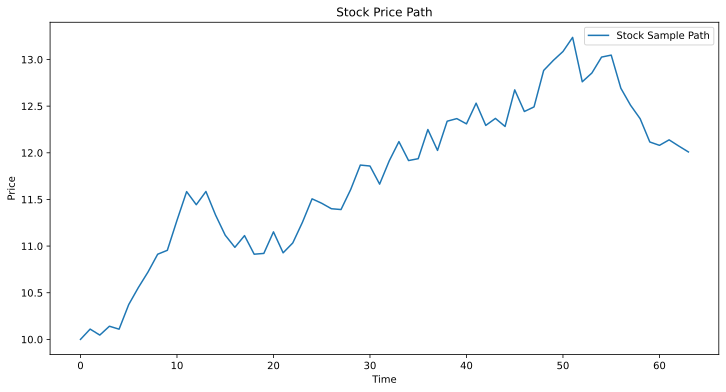

In [6]:
# Try and select a In-the-money case
sample_seq = 1

# Plot Sample path
plt.figure(figsize=(12, 6))
plt.plot(paths[sample_seq,:], label='Stock Sample Path')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Path')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Position')

Text(0.5, 1.0, 'Position Trajectory: Delta vs Delta-Gamma Hedging')

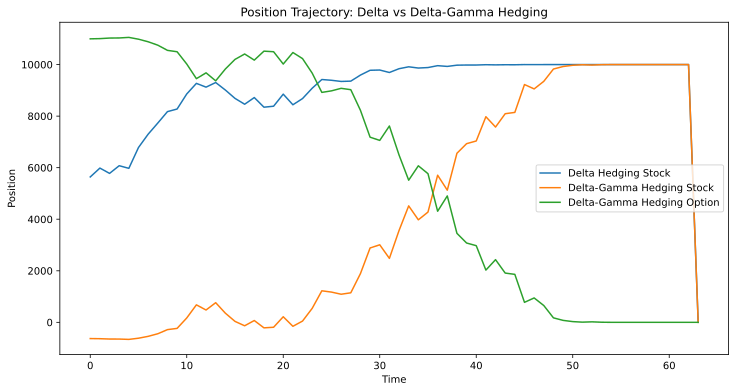

In [7]:
# Plot Position Trajectory
plt.figure(figsize=(12, 6))
plt.plot(pnl_delta[1][sample_seq,:], label='Delta Hedging Stock')
plt.plot(pnl_delta_gamma[1][sample_seq,:], label='Delta-Gamma Hedging Stock')
plt.plot(pnl_delta_gamma[2][sample_seq,:], label='Delta-Gamma Hedging Option')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position Trajectory: Delta vs Delta-Gamma Hedging')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Stock Price Path')

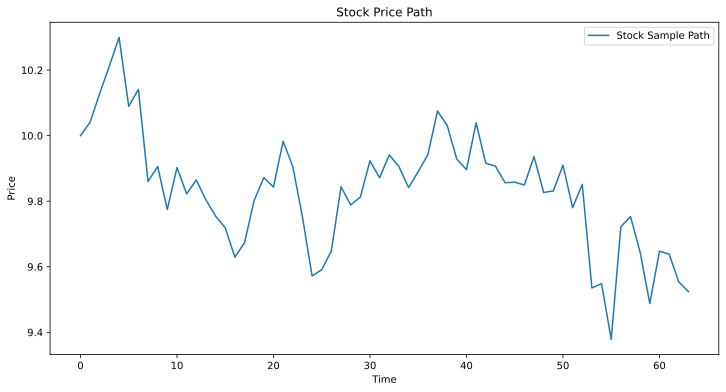

In [11]:
# Try and select a Off-the-money case
sample_seq = 4

# Plot Sample path
plt.figure(figsize=(12, 6))
plt.plot(paths[sample_seq,:], label='Stock Sample Path')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Path')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Position')

Text(0.5, 1.0, 'Position Trajectory: Delta vs Delta-Gamma Hedging')

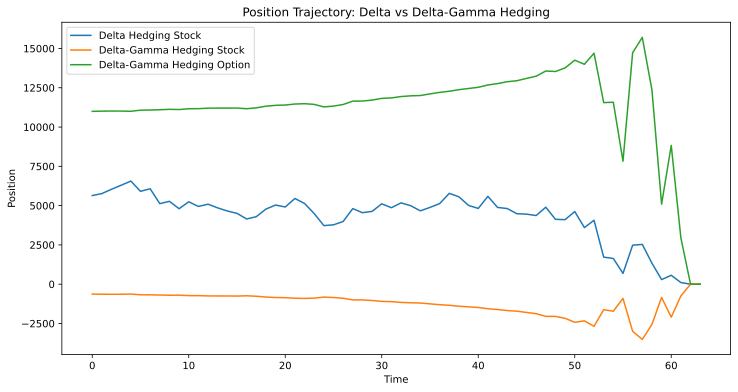

In [12]:
# Plot Position Trajectory
plt.figure(figsize=(12, 6))
plt.plot(pnl_delta[1][sample_seq,:], label='Delta Hedging Stock')
plt.plot(pnl_delta_gamma[1][sample_seq,:], label='Delta-Gamma Hedging Stock')
plt.plot(pnl_delta_gamma[2][sample_seq,:], label='Delta-Gamma Hedging Option')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position Trajectory: Delta vs Delta-Gamma Hedging')
plt.legend()
plt.show()

### Q3. Plot PnL Distribution as $\sigma_{real}$ varys

100%|██████████| 5000/5000 [05:39<00:00, 14.72it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   3.,   0.,   1.,   0.,   1.,   1.,
          3.,   2.,   3.,   2.,   2.,   5.,   2.,   2.,   6.,   6.,  13.,
         16.,  21.,  15.,  25.,  45.,  42.,  52.,  85.,  74.,  87., 125.,
        131., 137., 185., 151., 154., 203., 171., 202., 194., 185., 161.,
        212., 173., 157., 155., 128., 143., 126., 140., 135., 110.,  80.,
         83.,  90.,  79.,  87.,  68.,  56.,  63.,  45.,  39.,  38.,  39.,
         42.,  32.,  27.,  21.,  23.,   9.,  15.,  16.,   7.,   7.,   7.,
          7.,   1.,   7.,   3.,   0.,   1.,   1.,   2.,   4.,   2.,   0.,
          1.]),
 array([-1790.77201447, -1745.02115203, -1699.2702896 , -1653.51942716,
        -1607.76856472, -1562.01770228, -1516.26683984, -1470.5159774 ,
        -1424.76511497, -1379.01425253, -1333.26339009, -1287.51252765,
        -1241.76166521, -1196.01080278, -1150.25994034, -1104.5090779 ,
        -1058.75821546, -1013.

(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   2.,   3.,   2.,
          1.,   2.,   2.,   0.,   5.,   1.,   2.,   3.,   4.,   1.,   1.,
          4.,   5.,   3.,   0.,   5.,   1.,   4.,   7.,   1.,   3.,   7.,
          5.,   4.,   3.,   4.,   4.,   2.,   4.,   7.,   2.,   8.,   2.,
         12.,   8.,  10.,  17.,  20.,  41.,  29.,  57.,  53.,  47.,  91.,
         99., 149., 152., 242., 305., 387., 535., 628., 614., 367., 301.,
        358., 303.,  36.,   3.,   3.,   1.,   0.,   0.,   2.,   2.,   0.,
          1.]),
 array([-3238.86256178, -3204.54591931, -3170.22927684, -3135.91263438,
        -3101.59599191, -3067.27934944, -3032.96270697, -2998.64606451,
        -2964.32942204, -2930.01277957, -2895.69613711, -2861.37949464,
        -2827.06285217, -2792.7462097 , -2758.42956724, -2724.11292477,
        -2689.7962823 , -2655.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with real vol 0.20')

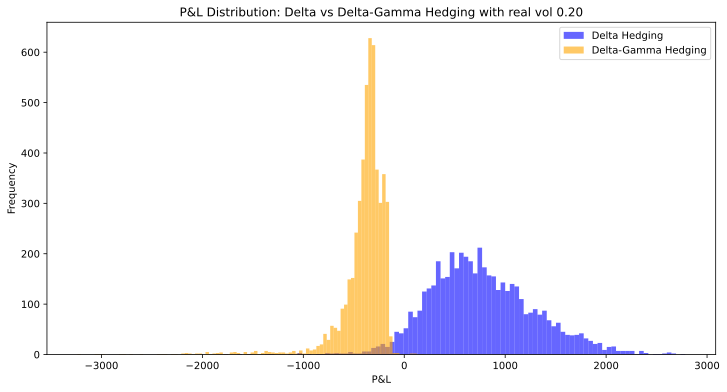

100%|██████████| 5000/5000 [05:34<00:00, 14.96it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   3.,   1.,   2.,
          0.,   1.,   2.,   4.,   3.,   1.,   5.,   5.,   6.,   9.,   5.,
          5.,   9.,  12.,  16.,  17.,  22.,  27.,  39.,  53.,  64., 100.,
        109., 142., 176., 189., 256., 240., 306., 319., 307., 261., 284.,
        248., 242., 224., 190., 174., 135., 116., 108.,  86.,  72.,  84.,
         43.,  54.,  52.,  25.,  25.,  24.,  27.,  13.,  14.,  10.,   4.,
          2.,   6.,   2.,   5.,   2.,   4.,   1.,   3.,   0.,   0.,   0.,
          1.]),
 array([-4011.86749805, -3944.28504909, -3876.70260013, -3809.12015117,
        -3741.53770221, -3673.95525325, -3606.37280429, -3538.79035533,
        -3471.20790637, -3403.62545741, -3336.04300845, -3268.46055949,
        -3200.87811053, -3133.29566157, -3065.71321261, -2998.13076364,
        -2930.54831468, -2862.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,
          0.,   0.,   1.,   2.,   1.,   3.,   1.,   2.,   0.,   1.,   1.,
          1.,   2.,   2.,   2.,   2.,   2.,   1.,   5.,   1.,   2.,   3.,
          6.,   2.,   5.,   5.,   4.,   4.,   4.,   4.,   3.,   4.,   2.,
          6.,   7.,   6.,  10.,  10.,   8.,   9.,  15.,  14.,  18.,  18.,
         41.,  56.,  77.,  74., 133., 147., 239., 315., 437., 685., 826.,
        624., 407., 482., 239.,   4.,   2.,   2.,   0.,   0.,   0.,   1.,
          1.]),
 array([-4454.36651263, -4407.33221542, -4360.2979182 , -4313.26362098,
        -4266.22932376, -4219.19502654, -4172.16072933, -4125.12643211,
        -4078.09213489, -4031.05783767, -3984.02354045, -3936.98924324,
        -3889.95494602, -3842.9206488 , -3795.88635158, -3748.85205436,
        -3701.81775715, -3654.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with real vol 0.22')

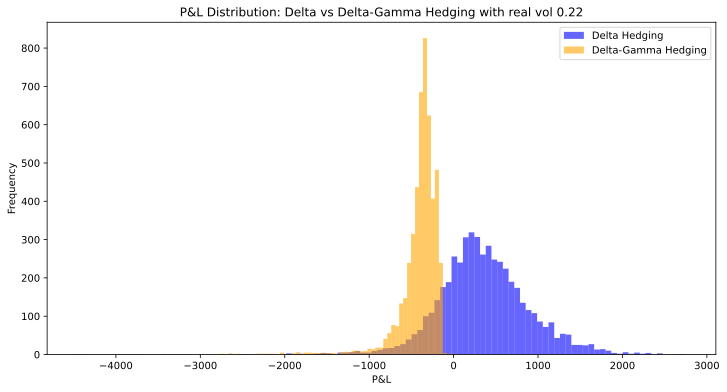

100%|██████████| 5000/5000 [05:37<00:00, 14.83it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   2.,   1.,   1.,   0.,   1.,   0.,   1.,   1.,
          0.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,   5.,   2.,   1.,
          1.,   1.,   0.,   9.,   7.,  12.,  11.,   9.,   7.,  15.,  18.,
         19.,  19.,  26.,  37.,  36.,  53.,  53.,  69.,  82., 116., 156.,
        163., 192., 235., 280., 320., 295., 323., 300., 308., 314., 247.,
        226., 178., 161., 138., 117.,  86.,  81.,  43.,  45.,  39.,  32.,
         24.,  15.,  14.,  11.,   4.,   8.,   4.,   5.,   4.,   2.,   2.,
          2.]),
 array([-5334.39022456, -5261.12370854, -5187.85719252, -5114.5906765 ,
        -5041.32416047, -4968.05764445, -4894.79112843, -4821.52461241,
        -4748.25809639, -4674.99158036, -4601.72506434, -4528.45854832,
        -4455.1920323 , -4381.92551628, -4308.65900025, -4235.39248423,
        -4162.12596821, -4088.

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 8.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 6.000e+00, 3.000e+00, 4.000e+00, 8.000e+00,
        7.000e+00, 3.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 1.100e+01,
        8.000e+00, 7.000e+00, 9.000e+00, 7.000e+00, 1.400e+01, 1.600e+01,
        2.300e+01, 4.300e+01, 8.300e+0

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with real vol 0.24')

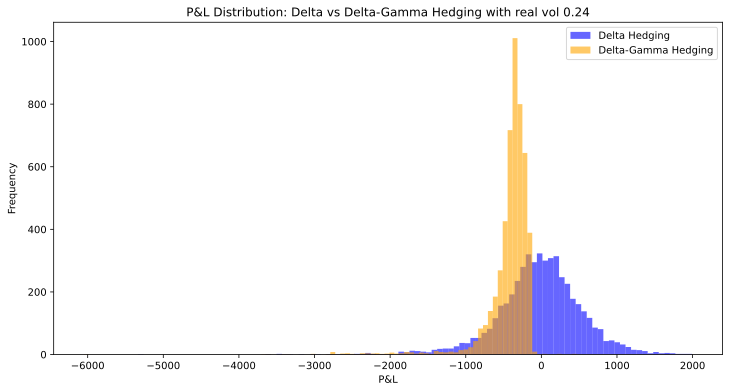

100%|██████████| 5000/5000 [05:40<00:00, 14.68it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   1.,   0.,   1.,   2.,   1.,   2.,   0.,   2.,
          3.,   2.,   3.,   2.,   2.,   2.,   1.,   6.,   5.,   4.,   1.,
         10.,   6.,   7.,  12.,   8.,  13.,  13.,  18.,  16.,  27.,  28.,
         30.,  30.,  23.,  38.,  61.,  60.,  62.,  70.,  96., 104., 107.,
        119., 147., 156., 182., 222., 225., 244., 251., 284., 297., 295.,
        247., 230., 204., 195., 157., 116., 108.,  92.,  69.,  52.,  51.,
         34.,  27.,  22.,  21.,   8.,  14.,  12.,  11.,   3.,   5.,   1.,
          4.,   1.,   3.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,
          1.]),
 array([-4480.27997106, -4415.15515814, -4350.03034523, -4284.90553231,
        -4219.78071939, -4154.65590648, -4089.53109356, -4024.40628064,
        -3959.28146773, -3894.15665481, -3829.03184189, -3763.90702898,
        -3698.78221606, -3633.65740314, -3568.53259023, -3503.40777731,
        -3438.2829644 , -3373.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   0.,   2.,
          2.,   1.,   0.,   0.,   2.,   2.,   0.,   6.,   0.,   3.,   2.,
          1.,   5.,   1.,   2.,   4.,   3.,   1.,   2.,   5.,   3.,   3.,
          1.,   0.,   4.,   3.,   3.,   2.,   2.,   7.,   6.,   6.,   5.,
          4.,   3.,   9.,   9.,   5.,   6.,  10.,  15.,  17.,  14.,  35.,
         49.,  79.,  92.,  95., 147., 215., 266., 377., 573., 811., 783.,
        491., 607., 177.,   4.,   4.,   1.,   0.,   3.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.]),
 array([-4632.07088592, -4575.51596533, -4518.96104474, -4462.40612415,
        -4405.85120357, -4349.29628298, -4292.74136239, -4236.1864418 ,
        -4179.63152122, -4123.07660063, -4066.52168004, -4009.96675946,
        -3953.41183887, -3896.85691828, -3840.30199769, -3783.74707711,
        -3727.19215652, -3670.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with real vol 0.26')

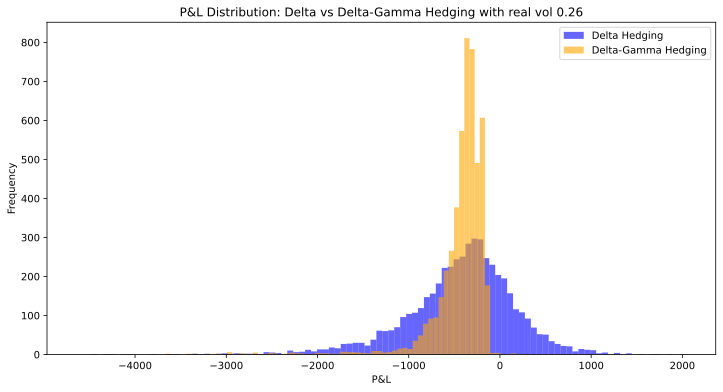

100%|██████████| 5000/5000 [05:40<00:00, 14.70it/s]


<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   2.,   1.,   1.,   1.,   1.,   2.,   2.,   1.,   2.,   6.,
          4.,   2.,   6.,   5.,   8.,   5.,   7.,   8.,   8.,   7.,   5.,
         11.,  16.,  16.,  16.,  19.,  27.,  19.,  25.,  27.,  46.,  47.,
         39.,  59.,  56.,  49.,  76.,  92.,  80., 116., 130., 108., 162.,
        170., 165., 189., 199., 257., 252., 257., 262., 268., 295., 263.,
        208., 206., 188., 133.,  87.,  64.,  55.,  48.,  29.,  20.,  17.,
         13.,   5.,   6.,   8.,   4.,   1.,   2.,   0.,   0.,   0.,   1.,
          1.]),
 array([-6.21310803e+03, -6.13646890e+03, -6.05982977e+03, -5.98319064e+03,
        -5.90655150e+03, -5.82991237e+03, -5.75327324e+03, -5.67663411e+03,
        -5.59999498e+03, -5.52335585e+03, -5.44671671e+03, -5.37007758e+03,
        -5.29343845e+03, -5.21679932e+03, -5.14016019e+03, -5.06352106e+03,
        -4.986

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          2.,   1.,   2.,   0.,   4.,   0.,   0.,   1.,   4.,   2.,   3.,
          4.,   2.,   3.,   2.,   4.,   2.,   0.,   0.,   2.,   3.,   3.,
          4.,   2.,   3.,   4.,   0.,   3.,   4.,   3.,   9.,   2.,   2.,
          4.,   5.,  11.,  12.,  14.,  14.,  19.,  20.,  25.,  39.,  47.,
         59.,  82.,  90., 147., 207., 267., 399., 662., 874., 720., 594.,
        557.,  30.,   3.,   3.,   2.,   2.,   1.,   1.,   2.,   0.,   0.,
          1.]),
 array([-5549.12277822, -5488.30592742, -5427.48907662, -5366.67222582,
        -5305.85537502, -5245.03852422, -5184.22167342, -5123.40482263,
        -5062.58797183, -5001.77112103, -4940.95427023, -4880.13741943,
        -4819.32056863, -4758.50371783, -4697.68686703, -4636.87001624,
        -4576.05316544, -4515.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with real vol 0.28')

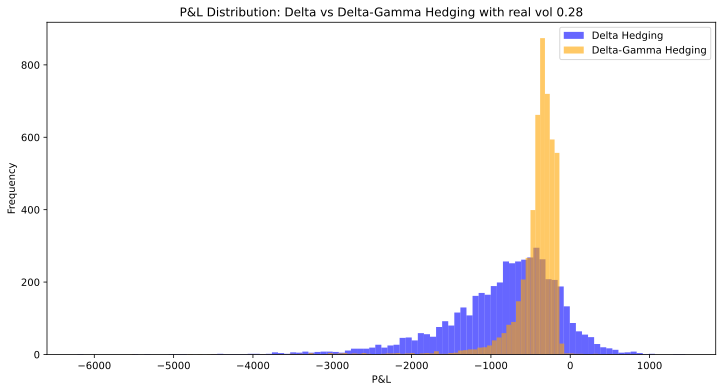

100%|██████████| 5000/5000 [05:44<00:00, 14.50it/s]


<Figure size 1200x600 with 0 Axes>

(array([  2.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   4.,
          0.,   3.,   3.,   1.,   2.,   1.,   5.,   4.,   4.,   2.,   4.,
          4.,   3.,  11.,   4.,   5.,   2.,   8.,   6.,  14.,  10.,  12.,
         14.,  21.,  18.,  22.,  24.,  15.,  24.,  30.,  32.,  28.,  51.,
         46.,  59.,  59.,  63.,  68.,  66.,  90.,  96.,  96.,  99., 109.,
        129., 130., 141., 159., 204., 159., 182., 201., 190., 235., 213.,
        219., 240., 236., 247., 206., 160., 128., 103.,  85.,  61.,  43.,
         33.,  12.,   6.,   9.,   6.,   4.,   2.,   2.,   1.,   2.,   1.,
          2.]),
 array([-6829.54752905, -6751.43305041, -6673.31857176, -6595.20409312,
        -6517.08961448, -6438.97513583, -6360.86065719, -6282.74617855,
        -6204.6316999 , -6126.51722126, -6048.40274262, -5970.28826397,
        -5892.17378533, -5814.05930669, -5735.94482804, -5657.8303494 ,
        -5579.71587075, -5501.

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   4.,   0.,   2.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   2.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,   2.,
          2.,   0.,   2.,   2.,   0.,   0.,   0.,   1.,   2.,   1.,   0.,
          2.,   3.,   3.,   1.,   2.,   5.,   5.,   3.,   4.,   0.,   3.,
          2.,   6.,   3.,   4.,   4.,   6.,   5.,   3.,   3.,   4.,   2.,
          6.,  12.,  11.,  11.,  17.,  16.,  23.,  23.,  25.,  53.,  63.,
         71.,  84., 110., 151., 215., 310., 435., 642., 850., 661., 589.,
        492.,  14.,   4.,   2.,   2.,   2.,   0.,   1.,   1.,   0.,   0.,
          2.]),
 array([-5562.5346087 , -5501.47465915, -5440.41470961, -5379.35476006,
        -5318.29481051, -5257.23486096, -5196.17491141, -5135.11496186,
        -5074.05501231, -5012.99506276, -4951.93511322, -4890.87516367,
        -4829.81521412, -4768.75526457, -4707.69531502, -4646.63536547,
        -4585.57541592, -4524.

Text(0.5, 0, 'P&L')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'P&L Distribution: Delta vs Delta-Gamma Hedging with real vol 0.30')

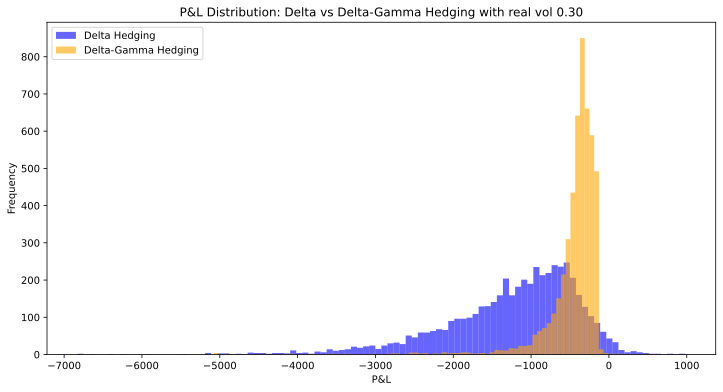

In [13]:
# Parameters
S0 = 10
K = 10
K_h = 10
T_g = 63 / 252  # 1/4 year
T_h = 0.3  # 0.3 year
r = 0.05
sigma = 0.25
sigma_real = 0.25
mu = 0.1
N = 10000
transaction_cost_stock = 0.005
transaction_cost_option = 0.005
num_paths = 5000

for sigma_real in [0.2, 0.22, 0.24, 0.26, 0.28, 0.3]:

    paths = hedging.simulate_asset_paths(num_paths, sigma_real)
    pnl_delta = hedging.delta_hedge(paths)
    pnl_delta_gamma = hedging.delta_gamma_hedge(paths)

    # Plot P&L distribution
    plt.figure(figsize=(12, 6))
    plt.hist(pnl_delta[0][:,-1], bins=100, alpha=0.6, label='Delta Hedging', color='blue')
    plt.hist(pnl_delta_gamma[0][:,-1], bins=100, alpha=0.6, label='Delta-Gamma Hedging', color='orange')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.title(f'P&L Distribution: Delta vs Delta-Gamma Hedging with real vol {sigma_real:.2f}')
    plt.legend()
    plt.show()